In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [5]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
   

                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                
                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                
                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector
                                

            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
            
            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {1-success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 85.90%
Success Probability Vector:
tensor([9.5464e-01, 2.4873e-03, 1.5876e-02, 2.5647e-03, 2.4969e-03, 2.2214e-04,
        7.8358e-04, 1.3870e-03, 1.4100e-02, 5.4444e-03], device='cuda:0')
Class 2 - Accuracy: 92.10%
Success Probability Vector:
tensor([2.7013e-03, 9.8520e-01, 5.9167e-04, 4.0014e-04, 8.4686e-06, 2.3219e-04,
        1.3201e-03, 5.0926e-05, 2.9844e-03, 6.5087e-03], device='cuda:0')
Class 3 - Accuracy: 75.10%
Success Probability Vector:
tensor([1.0818e-02, 5.8797e-04, 9.4770e-01, 1.2245e-02, 1.0319e-02, 6.7363e-03,
        7.4583e-03, 3.4869e-03, 5.3109e-04, 1.2411e-04], device='cuda:0')
Class 4 - Accuracy: 68.00%
Success Probability Vector:
tensor([0.0025, 0.0011, 0.0156, 0.8761, 0.0125, 0.0707, 0.0091, 0.0081, 0.0020,
        0.0023], device='cuda:0')
Class 5 - Accuracy: 79.50%
Success Probability Vector:
tensor([3.0799e-03, 1.1770e-05, 1.9703e-02, 8.6676e-03, 9.4040e-01, 6.059

In [4]:
test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=False)

# Initialize variables to store results
successful_norms = [[] for _ in range(10)]  # List to store successful data feature vector norms for each class
failed_norms = [[] for _ in range(10)]  # List to store failed data feature vector norms for each class

# Iterate over the test dataset and collect feature vector norms
for images, labels in test_dataloader:
    images = images.to(args.device)
    labels = labels.to(args.device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    norm = torch.norm(model.extract_features(images), dim=1).item()
    class_index = labels.item()

    if predicted == labels:  # Successful prediction
        successful_norms[class_index].append(norm)
    else:  # Failed prediction
        failed_norms[class_index].append(norm)

# Compute mean and variance of feature vector norms for each class
successful_means = [torch.tensor(norms).mean().item() for norms in successful_norms]
successful_variances = [torch.tensor(norms).var().item() for norms in successful_norms]

successful_min = [torch.tensor(norms).min().item() for norms in successful_norms]
successful_max = [torch.tensor(norms).max().item() for norms in successful_norms]

failed_means = [torch.tensor(norms).mean().item() for norms in failed_norms]
failed_variances = [torch.tensor(norms).var().item() for norms in failed_norms]
failed_min = [torch.tensor(norms).min().item() for norms in failed_norms]
failed_max = [torch.tensor(norms).max().item() for norms in failed_norms]

# Print the results
for class_index in range(10):
    print(f"Class {class_index + 1} (Successful): Mean = {successful_means[class_index]}, Variance = {successful_variances[class_index]}, Min = {successful_min[class_index]}, Max = {successful_max[class_index]}")
    print(f"Class {class_index + 1} (Failed): Mean = {failed_means[class_index]}, Variance = {failed_variances[class_index]}, Min = {failed_min[class_index]}, Max = {failed_max[class_index]}")

Class 1 (Successful): Mean = 13.456859588623047, Variance = 6.087619781494141, Min = 7.400328636169434, Max = 25.78520393371582
Class 1 (Failed): Mean = 11.075488090515137, Variance = 3.27142071723938, Min = 7.828159332275391, Max = 17.835323333740234
Class 2 (Successful): Mean = 17.997356414794922, Variance = 32.087860107421875, Min = 7.394448757171631, Max = 42.399261474609375
Class 2 (Failed): Mean = 11.548419952392578, Variance = 3.8947370052337646, Min = 8.007311820983887, Max = 17.259075164794922
Class 3 (Successful): Mean = 12.60632038116455, Variance = 6.087701320648193, Min = 7.638427734375, Max = 23.554048538208008
Class 3 (Failed): Mean = 10.864706993103027, Variance = 2.582793951034546, Min = 7.360509395599365, Max = 16.721370697021484
Class 4 (Successful): Mean = 12.072168350219727, Variance = 4.588443756103516, Min = 8.043844223022461, Max = 22.83197593688965
Class 4 (Failed): Mean = 11.347728729248047, Variance = 3.385434627532959, Min = 7.718227386474609, Max = 20.90193

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data)

In [5]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [5]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)
                    
                print(before_acc_results)

                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                    
                    
                    


Files already downloaded and verified
Files already downloaded and verified
[91.0, 89.0, 69.0, 81.0, 83.0, 79.0, 70.0, 77.0, 86.0, 81.0, 82.0, 87.0, 88.0, 92.0, 77.0, 84.0, 70.0, 86.0, 86.0, 72.0, 76.0, 79.0, 88.0, 81.0, 77.0, 81.0, 81.0, 85.0, 83.0, 83.0, 80.0, 74.0, 86.0, 78.0, 80.0, 78.0, 75.0, 75.0, 77.0, 78.0, 84.0, 83.0, 82.0, 75.0, 83.0, 84.0, 81.0, 79.0, 85.0, 79.0, 72.0, 80.0, 89.0, 90.0, 93.0, 82.0, 75.0, 84.0, 73.0, 82.0, 82.0, 89.0, 84.0, 87.0, 75.0, 77.0, 86.0, 78.0, 77.0, 78.0, 88.0, 81.0, 84.0, 92.0, 79.0, 82.0, 80.0, 76.0, 88.0, 81.0, 81.0, 82.0, 89.0, 84.0, 76.0, 79.0, 82.0, 78.0, 69.0, 72.0, 81.0, 80.0, 83.0, 84.0, 82.0, 86.0, 88.0, 84.0, 86.0, 78.0]
Before min/max/mean/std of accuracy
69.0 93.0 81.28 5.27


In [6]:
    print(">>> Distributing client train data...")
    traindata_cls_dict = record_net_data_stats(dict_users_train, np.array(dataset_train.targets))
    print('Data statistics: %s' % str(traindata_cls_dict))

>>> Distributing client train data...
Data statistics: {0: {0: 200, 1: 100, 9: 200}, 1: {1: 100, 6: 300, 8: 100}, 2: {1: 100, 3: 200, 6: 100, 8: 100}, 3: {1: 100, 3: 100, 4: 100, 7: 200}, 4: {0: 100, 4: 200, 5: 100, 7: 100}, 5: {0: 200, 1: 100, 4: 100, 5: 100}, 6: {2: 200, 5: 100, 6: 100, 9: 100}, 7: {3: 100, 4: 100, 5: 100, 6: 100, 8: 100}, 8: {2: 100, 3: 100, 7: 100, 8: 200}, 9: {0: 100, 4: 100, 6: 100, 7: 200}, 10: {3: 100, 4: 200, 6: 100, 7: 100}, 11: {7: 400, 9: 100}, 12: {0: 200, 1: 100, 8: 100, 9: 100}, 13: {0: 100, 1: 100, 8: 200, 9: 100}, 14: {0: 100, 3: 100, 4: 100, 5: 100, 8: 100}, 15: {1: 100, 4: 200, 7: 100, 9: 100}, 16: {2: 100, 5: 300, 6: 100}, 17: {1: 100, 7: 100, 9: 300}, 18: {1: 100, 6: 100, 7: 100, 9: 200}, 19: {2: 400, 3: 100}, 20: {2: 100, 3: 100, 4: 200, 7: 100}, 21: {1: 100, 3: 100, 4: 100, 5: 100, 6: 100}, 22: {1: 200, 7: 100, 8: 100, 9: 100}, 23: {0: 100, 5: 200, 6: 100, 7: 100}, 24: {5: 200, 6: 100, 7: 200}, 25: {3: 100, 5: 100, 7: 100, 8: 100, 9: 100}, 26: {2

In [7]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {0: 40, 1: 20, 9: 40}, 1: {1: 20, 6: 60, 8: 20}, 2: {1: 20, 3: 40, 6: 20, 8: 20}, 3: {1: 20, 3: 20, 4: 20, 7: 40}, 4: {0: 20, 4: 40, 5: 20, 7: 20}, 5: {0: 40, 1: 20, 4: 20, 5: 20}, 6: {2: 40, 5: 20, 6: 20, 9: 20}, 7: {3: 20, 4: 20, 5: 20, 6: 20, 8: 20}, 8: {2: 20, 3: 20, 7: 20, 8: 40}, 9: {0: 20, 4: 20, 6: 20, 7: 40}, 10: {3: 20, 4: 40, 6: 20, 7: 20}, 11: {7: 80, 9: 20}, 12: {0: 40, 1: 20, 8: 20, 9: 20}, 13: {0: 20, 1: 20, 8: 40, 9: 20}, 14: {0: 20, 3: 20, 4: 20, 5: 20, 8: 20}, 15: {1: 20, 4: 40, 7: 20, 9: 20}, 16: {2: 20, 5: 60, 6: 20}, 17: {1: 20, 7: 20, 9: 60}, 18: {1: 20, 6: 20, 7: 20, 9: 40}, 19: {2: 80, 3: 20}, 20: {2: 20, 3: 20, 4: 40, 7: 20}, 21: {1: 20, 3: 20, 4: 20, 5: 20, 6: 20}, 22: {1: 40, 7: 20, 8: 20, 9: 20}, 23: {0: 20, 5: 40, 6: 20, 7: 20}, 24: {5: 40, 6: 20, 7: 40}, 25: {3: 20, 5: 20, 7: 20, 8: 20, 9: 20}, 26: {2: 20, 3: 20, 9: 60}, 27: {0: 40, 7: 40, 9: 20}, 28: {1: 20, 2: 40, 3: 20, 6: 20}, 29: {0: 20, 1: 40,

In [8]:
    head_params = [p for name, p in net_local_list[0].named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([-0.0641, -0.2879,  0.2214,  0.3364,  0.4022, -0.2278, -0.0236, -0.2832,
         0.1133, -0.1665], device='cuda:0', requires_grad=True)
Weight norm square of each class part of classifier
tensor([2.3621, 2.6288, 2.4299, 2.4486, 2.8616, 2.2699, 2.5626, 2.3746, 2.6708,
        2.5316], device='cuda:0', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000e+00,  4.4151e-02, -1.6576e-01, -1.8233e-01, -1.0407e-01,
         -1.8692e-01, -2.3328e-01, -1.6763e-01,  1.3988e-01,  3.4718e-05],
        [ 4.4151e-02,  1.0000e+00, -1.8366e-01, -2.4655e-01, -3.4043e-01,
         -1.6912e-01, -1.5117e-01, -2.4807e-01,  5.3943e-02,  2.8898e-01],
        [-1.6576e-01, -1.8366e-01,  1.0000e+00, -3.9946e-02, -2.8198e-02,
         -4.3520e-02, -3.9386e-02,  6.2539e-03, -1.6223e-01, -1.4310e-01],
        [-1.8233e-01, -2.4655e-01, -3.9946e-02,  1.0000e+00,  8.8758e-02,
          2.4352e-04, -5.139

Weight norm of each class part of classifier
tensor([1.5369, 1.6214, 1.5588, 1.5648, 1.6916, 1.5066, 1.6008, 1.5410, 1.6343,
        1.5911], device='cuda:0', grad_fn=<SqrtBackward0>)


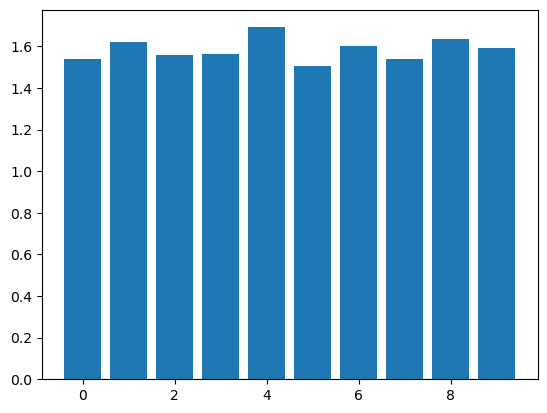

In [9]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

# HeatMap of weight bias

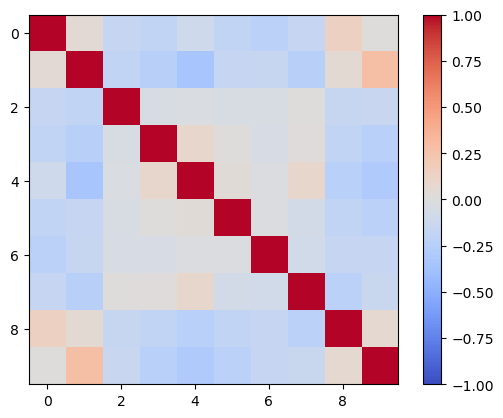

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [11]:
                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.930073, 1: 0.9556405, 2: 0.8960758, 3: 0.897366, 4: 0.9072696, 5: 0.9176217, 6: 0.92112863, 7: 0.9345111, 8: 0.94871485, 9: 0.9346718}
-------------------VAR-------------------
{0: 0.007567794, 1: 0.006938069, 2: 0.0094616, 3: 0.008643649, 4: 0.008110442, 5: 0.008388246, 6: 0.009515411, 7: 0.007899408, 8: 0.0065401476, 9: 0.008503965}


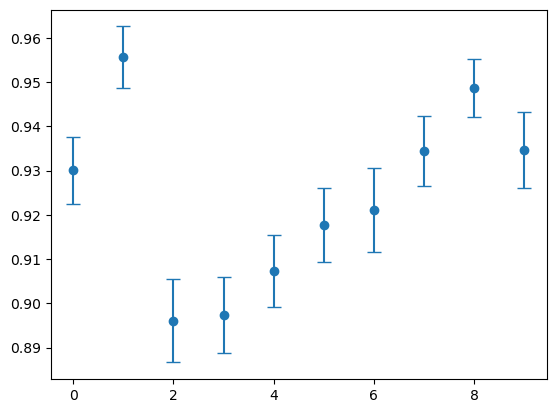

In [12]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [13]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [5]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.01,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 0,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': False,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}/decay_0.1/fn_{}/seed_0/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)
                
 
                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
    
                dict_save_path = 'dict_users_10_{}.pkl'.format(args.shard_per_user)
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)
    

                # build model
                net_glob = get_model(args)
                net_glob.train()
                

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []
                
                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                net_local_list[0].eval()
                
                label= [i for i in range(num_classes)]                    


                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = net_local_list[0].extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]

                print(class_mean_dict)
                #Get a Inner product of each class's centroid vector

                sorted_keys=sorted(class_mean_dict)
                print(sorted_keys)

                class_mean_lst=[]


                for key in sorted_keys:
                    class_mean_lst.append(class_mean_dict[key])

                class_mean_lst=torch.stack(class_mean_lst)


                print(class_mean_lst.shape)
                print(class_mean_lst.transpose(0,1).shape)

                #Get the each centroid vector's norm
                print("-------------Norm of each centroid vectors --------------")
                print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


                #Get the cosine similarity result between eacn centroid vectors


                normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
                print("-------------Cosine similarity of Each Centroid vectors--------------")
                print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())
                    
                    
    


Files already downloaded and verified
Files already downloaded and verified
{0: tensor([7.6246e-01, 5.1240e-01, 1.2625e+00, 3.0032e-02, 2.3566e-01, 1.8430e-05,
        6.6486e-01, 1.1750e+00, 1.4744e+00, 5.1102e-03, 0.0000e+00, 1.7933e-01,
        1.5370e-01, 7.6085e-01, 3.3484e-02, 5.4135e-01, 9.1308e-01, 9.5066e-01,
        6.7464e-02, 5.7545e-02, 1.6526e-02, 7.2374e-01, 2.2600e-01, 2.0948e-01,
        6.1709e-01, 2.5593e-01, 1.4804e-01, 7.9243e-01, 1.6269e-01, 1.8604e-03,
        2.9565e-04, 4.8778e-02, 1.8894e+00, 4.6114e-01, 1.1781e-01, 0.0000e+00,
        7.8360e-03, 1.8266e-04, 9.1564e-02, 3.4151e-01, 2.4507e+00, 0.0000e+00,
        9.3670e-03, 2.2999e-01, 2.6519e-01, 9.4251e-01, 3.0350e-01, 3.0569e-01,
        2.1491e-01, 5.4257e-01, 5.9395e-03, 3.8133e-01, 1.6357e-01, 2.4316e-01,
        1.1622e+00, 0.0000e+00, 6.8182e-01, 5.4656e-01, 6.6192e-01, 2.7550e-01,
        7.4957e-01, 1.2818e-01, 0.0000e+00, 2.1238e-02, 2.7529e-01, 1.9412e-01,
        5.2268e-01, 6.4823e-03, 1.0554e-

# Cosine Similarity of Centroid Vectors

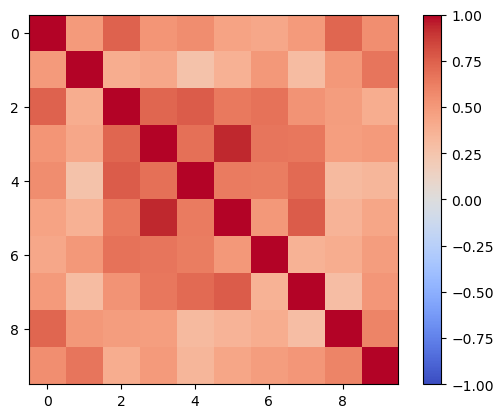

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [15]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[0.9999999  0.49743053 0.7405349  0.5165383  0.5578434  0.45042714
  0.42915466 0.4948747  0.72645414 0.5472332 ]
 [0.49743053 1.         0.39801258 0.42751905 0.26560482 0.37061533
  0.50650376 0.30366433 0.50410926 0.6578187 ]
 [0.7405349  0.39801258 0.9999998  0.7193956  0.76037234 0.64485765
  0.673983   0.5268886  0.47878593 0.39581695]
 [0.5165383  0.42751905 0.7193956  1.0000001  0.6803465  0.93454885
  0.6619922  0.6552124  0.4720168  0.4944045 ]
 [0.5578434  0.26560482 0.76037234 0.6803465  1.         0.6369677
  0.63208014 0.7083717  0.3157679  0.34345183]
 [0.45042714 0.37061533 0.64485765 0.93454885 0.6369677  0.9999999
  0.50498563 0.76161003 0.35492623 0.4311993 ]
 [0.42915466 0.50650376 0.673983   0.6619922  0.63208014 0.50498563
  1.0000001  0.36347088 0.39417404 0.47657433]
 [0.4948747  0.30366433 0.5268886  0.6552124  0.7083717  0.76161003
  0.36347088 1.         0.28973883 0.51026124]
 [0.72645414 0.50410926 0.47878593 0.4720168  0.3157679  0

# Centroid-Feature Alignment

In [16]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.5497, 0.6614, 0.5318, 0.4027, 0.5281, 0.4882, 0.5883, 0.5517, 0.6095,
        0.6019], device='cuda:0', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.5497, 0.6614, 0.5318, 0.4027, 0.5281, 0.4882, 0.5883, 0.5517, 0.6095,
        0.6019], device='cuda:0', grad_fn=<DiagonalBackward0>)


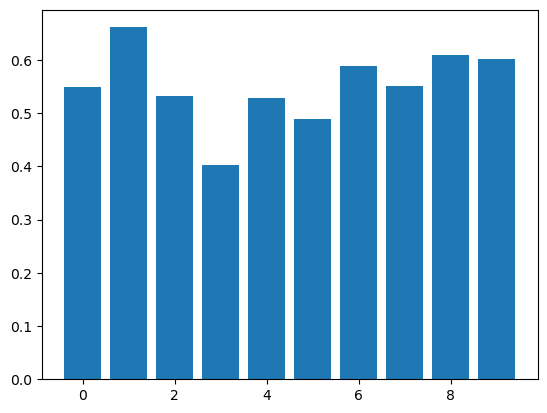

In [17]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()